# Assignment 11-Part2: Convolutional Neural Networks with PyTorch

In this assignment, you will learn how to use PyTorch for deep learning at the example of image classification with Convlutional neural network. You are free to use any packages from the standard library and third-party libraries. However, to solve the assignment you will only need numpy, matplotlib, torch, and torchvision.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

- Your names here.

## Installation

Go to [PyTorch/Get Started](https://pytorch.org/get-started/locally/) to find installation instructions for torch and torchvisio for your specific hardware, operating system, and Python environment. If you are unsure about your hardware, select CPU as Compute Platform.

For example, installing for Windows via pip on CPU requires the following command:
```shell
pip3 install torch torchvision torchaudio
```

You might need to adjust some code in the following tasks, if you want to run it on a GPU.

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils import data
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## MNIST Dataset

We use the popular MNIST dataset in this assignment. The dataset will be automatically downloaded to the directory specified by `root` with the code in the following cell.

In [2]:
mnist_train = MNIST(root='mnist', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='mnist', train=False, download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 88633398.17it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22121200.48it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26721370.08it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20074319.04it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



The MNIST dataset consists of gray-scale images with a resolution of 28x28 depicting handwritten numbers from 0 to 9. In this assignment, we want to categorize images according to their depicted number. Accordingly, we are facing a multi-class classification problem.

Let us first look at instances of the data.

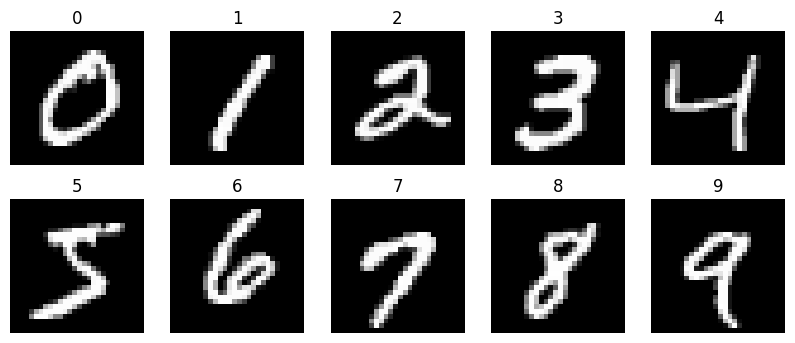

In [3]:
examples = []
for target in range(10):
    for img, label in mnist_train:
        if target == label:
            examples.append(img)
            break

fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for label, img in enumerate(examples):
    col = label % 5
    row = label // 5
    ax[row, col].imshow(img.squeeze(), cmap='gray')
    ax[row, col].set_title(f'{label}')
    ax[row, col].axis('off')

The variables `mnist_train` and `mnist_test` are instances of [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), which implements the `__getitem__()` method and the `__len__()`. These methods are special methods that enable convinient usage, which we will demonstrate in the following cell.

In [4]:
# __getitem__ allows indexing similar to a list or dictionary.
# The MNIST class returns a tuple of image tensor and label.
img, label = mnist_train[0]
print('Shape of image tensor:', img.shape)

# __len__ allows calling len.
n_samples = len(mnist_train)
print('#Training samples:', n_samples)

Shape of image tensor: torch.Size([1, 28, 28])
#Training samples: 60000


## Tensors

The images returned by `mnist_train` are already Torch tensors.


In [5]:
print('Tensor shape:', img.shape)
print('Tensor datatype:', img.dtype)
print('Slicing:', img[:, 3:5, 3:5])
print('Mean across columns', torch.mean(img, dim=1))

Tensor shape: torch.Size([1, 28, 28])
Tensor datatype: torch.float32
Slicing: tensor([[[0., 0.],
         [0., 0.]]])
Mean across columns tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0268, 0.0595, 0.0696, 0.1042, 0.1784,
         0.1987, 0.2217, 0.2937, 0.3588, 0.3777, 0.3048, 0.3031, 0.3360, 0.3667,
         0.2458, 0.1585, 0.0794, 0.0775, 0.0674, 0.0268, 0.0000, 0.0000, 0.0000,
         0.0000]])


Notice that images are returned as three-dimensional tensors.

The first dimension is the batch dimension. Querying the dataset for a single instance returns a batch of size 1.

The second and third dimensions correspond to pixel width and pixel height of the image respectively. Because the images are greyscale, the color of each pixel can be represented by a scalar. For color images, a fourth dimension would be needed.

# Task 7: Convolutional Neural Network

In this task, you will implement a convolutional neural network (CNN) with Torch.

Follow the steps from the previous task:
- Implement a module for the CNN.
- Train the CNN.
- Evaluate the CNN.

You are free to design the architecture however you prefer. The network should accept inputs of  shape `(batch_size, 28, 28)` and output tensors of shape `(batch_size, 10)`. Your model will need 2d convolution layers, pooling layers, and a number of dense layers at the output.

Your model must implement at least one form of regularization either as part of the architecture or as part of the training procedure.

Feel free to reuse code from the previous task.

*Hint: Check the lecture slides for example CNN architectures as seen on slide "Simple end-to-end convolutional neural network" or "The paper that started the deep learning hype: AlexNet".*

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # (batch, 1, 28, 28)
            nn.Conv2d(1, 16, 5),
            # -> (batch, 16, 24, 24)
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # -> (batch, 1, 12, 12)
            nn.Conv2d(16, 32, 5),
            # -> (batch, 32, 8, 8)
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # -> (batch, 32, 4, 4)
            nn.Flatten(1),
            # -> (batch, 32*4*4)
            nn.Linear(32*4*4, 64),
            # -> (batch, 64)
            nn.ReLU(),
            nn.Linear(64, 10)
            # -> (batch, 10)
        )

    def forward(self, x):
        return self.network.forward(x)

In [7]:
device = 'cpu'
cnn = CNN().to(device)

epochs = 10
batch_size = 128 # Increase this if training is too slow.

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(cnn.parameters(), lr=0.01)

train_loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    epoch_loss = 0.0

    for imgs, labels in train_loader:
        optimizer.zero_grad()

        labels_pred = cnn.forward(imgs.to(device))
        loss = loss_function(labels_pred, labels.to(device))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().cpu().item()

    print(f'Loss ({epoch+1}/{epochs}): {epoch_loss:.3f}')


Loss (1/10): 85.720
Loss (2/10): 37.243
Loss (3/10): 31.940
Loss (4/10): 29.430
Loss (5/10): 28.319
Loss (6/10): 28.414
Loss (7/10): 28.471
Loss (8/10): 27.930
Loss (9/10): 27.021
Loss (10/10): 27.507



After training your neural network, you need to evaluate its performance given the test dataset `mnist_test`.

Compute and display the following using the test dataset:
- Confusion matrix
- Micro F1-score per class
- One incorrectly classified instance per class.

During evaluation, you need to turn off dropoff. Additionally, computing and storing gradients is not needed during evaluation. You can turn off such operations by executing `fnn.eval()` before making any predictions.

In [8]:
from sklearn.metrics import confusion_matrix, f1_score

cnn.eval()

imgs, labels = next(iter(data.DataLoader(mnist_test, batch_size=len(mnist_test))))

labels_pred = cnn.forward(imgs.to(device))

labels = labels.detach().cpu().numpy()
labels_pred = np.argmax(labels_pred.detach().cpu().numpy(), axis=1)

confusion_matrix(labels, labels_pred)

array([[ 971,    1,    0,    0,    0,    0,    3,    1,    2,    2],
       [   0, 1128,    0,    1,    2,    2,    0,    2,    0,    0],
       [   1,    8,  991,    2,    1,    0,    0,   26,    3,    0],
       [   0,    0,    0, 1002,    0,    1,    0,    2,    3,    2],
       [   1,    3,    0,    0,  940,    0,    3,    8,    1,   26],
       [   0,    0,    0,   11,    0,  869,    2,    2,    4,    4],
       [   2,    3,    2,    0,    5,    1,  939,    0,    6,    0],
       [   0,    1,    1,    0,    1,    0,    0, 1020,    1,    4],
       [   0,    1,    2,    0,    0,    0,    0,    3,  963,    5],
       [   0,    1,    0,    2,    4,    2,    0,    6,    0,  994]])

In [9]:
f1 = f1_score(labels, labels_pred, average='micro')
print(f'F1 score: {f1:.4f}')

F1 score: 0.9817


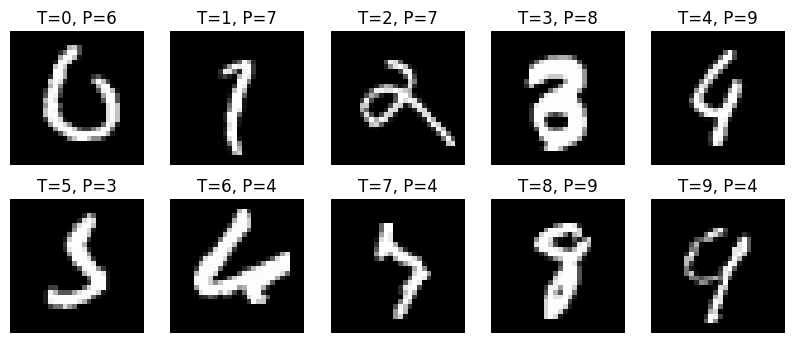

In [10]:
examples = []
for target in range(10):
    for true_label, wrong_label, correct, img in zip(
        labels.tolist(),
        labels_pred.tolist(),
        (labels == labels_pred).tolist(),
        list(imgs.detach().cpu().numpy())
    ):
        if target == true_label and not correct:
            examples.append((img, wrong_label))
            break

fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for label, (img, wrong_label) in enumerate(examples):
    col = label % 5
    row = label // 5
    ax[row, col].imshow(img.squeeze(), cmap='gray')
    ax[row, col].set_title(f'T={label}, P={wrong_label}')
    ax[row, col].axis('off')